<a href="https://colab.research.google.com/github/sbooeshaghi/azucar/blob/main/analysis/brain/obs13/annotate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [69]:
!pip install --quiet kb_python scanpy leidenalg
!apt-get install nvidia-cuda-toolkit

     |████████████████████████████████| 1.4 MB 7.7 MB/s 
     |████████████████████████████████| 3.1 MB 30.0 MB/s 


In [15]:
!git clone https://github.com/sbooeshaghi/azucar.git

Cloning into 'azucar'...
remote: Enumerating objects: 1047, done.
remote: Counting objects: 100% (488/488), done.
remote: Compressing objects: 100% (415/415), done.
remote: Total 1047 (delta 155), reused 257 (delta 64), pack-reused 559
Receiving objects: 100% (1047/1047), 1.60 GiB | 36.67 MiB/s, done.
Resolving deltas: 100% (377/377), done.
Checking out files: 100% (275/275), done.


In [97]:
#@title import
import os
import sys
import matplotlib.pyplot as plt
from sklearn.metrics import rand_score
from mpl_toolkits.axes_grid1 import make_axes_locatable
import json
import pandas as pd
import numpy as np
import scanpy as sc
from sklearn.decomposition import PCA
from collections import defaultdict
from scipy.io import mmread, mmwrite
from scipy.sparse import csr_matrix
from sklearn.neighbors import KDTree
from scipy.stats import entropy
from itertools import combinations
from kb_python.utils import import_matrix_as_anndata

def nd(arr):
    return np.asarray(arr).reshape(-1)

def yex(ax):
    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
    ]

    # now plot both limits against eachother
    ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
    ax.set_aspect('equal')
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    return ax

fsize=20

plt.rcParams.update({'font.size': fsize})
%config InlineBackend.figure_format = 'retina'

In [158]:
sample = "brain"
observation = "obs13"

base_data = f"azucar/analysis/{sample}/{observation}/out"
base_mark = f"azucar/analysis/{sample}/{observation}/assign"
base_ref  = f"azucar/reference/{sample}/cdna"

# path for assignments
asn_obs = "obs14"
base_asn = f"azucar/analysis/{sample}/{asn_obs}/assign"
asn_fn = os.path.join(base_asn, "assignments.txt")

markers_fn = os.path.join(base_mark, "markers.txt")
matrix_fn  = os.path.join(base_data, "matrix.mtx")
genes_fn   = os.path.join(base_data, "genes.txt")
barcodes_fn   = os.path.join(base_data, "barcodes.txt")

t2g_fn = os.path.join(base_ref, "t2g.txt")

In [159]:
!gunzip $base_data/*.gz
!gunzip $base_asn/*.gz

In [160]:
# load cdna
adata = import_matrix_as_anndata(matrix_path=matrix_fn, barcodes_path=barcodes_fn, genes_path=genes_fn)

# load assignments
assignments = pd.read_csv(asn_fn, sep="\t", index_col=0)
cols = assignments.columns.values

# map data from assignments to cdna
for i in cols:
  adata.obs[i] = adata.obs.index.map(assignments[i])

# map gene name to cdna
t2g = pd.read_csv(t2g_fn, 
                  header = None, 
                  names=["tid", "gid", "gene", "transcript", "chrom", "start", "stop", "strand"], 
                  sep="\t")
t2g = t2g.drop_duplicates("gid")
t2g = t2g.set_index("gid")

# map gene names to gene
adata.var["gene"] = adata.var.index.map(t2g["gene"])

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [161]:
adata

AnnData object with n_obs × n_vars = 16556 × 55416
    obs: 'mtag3_ipf', 'mtag4_ipf', 'mtag1_ipf', 'mtag2_ipf', 'dbco_ipf', 'mtag1', 'mtag2', 'mtag3', 'mtag4', 'dbco', 'label_id', 'label', 'ent', 'mahalanobis_0', 'mahalanobis_1', 'mahalanobis_2', 'mahalanobis_3'
    var: 'gene'

In [162]:
# preprocessing
adata.layers["log1p"] = np.log1p(adata.X)

# TODO figure out why we have nan genes
adata = adata[:,adata.var.notna()["gene"]].copy()

# drop ribosomal and mitochondrial genes
dropgenes = np.logical_and(
    np.logical_and(
        ~adata.var.gene.str.upper().str.contains("RPL").values, 
        ~adata.var.gene.str.upper().str.startswith("MT-").values), 
    adata.var.gene.str.upper() != "MALAT1")
adata = adata[:,dropgenes].copy()

# drop the cells without assignments
adata = adata[adata.obs.notna()["label"]].copy()

adata

AnnData object with n_obs × n_vars = 11064 × 53580
    obs: 'mtag3_ipf', 'mtag4_ipf', 'mtag1_ipf', 'mtag2_ipf', 'dbco_ipf', 'mtag1', 'mtag2', 'mtag3', 'mtag4', 'dbco', 'label_id', 'label', 'ent', 'mahalanobis_0', 'mahalanobis_1', 'mahalanobis_2', 'mahalanobis_3'
    var: 'gene'
    layers: 'log1p'

In [163]:
conditions = np.unique(adata.obs.label.values)

data = {}
for c in conditions:
  data[c] = adata[adata.obs.eval(f"label == '{c}'").values].copy()

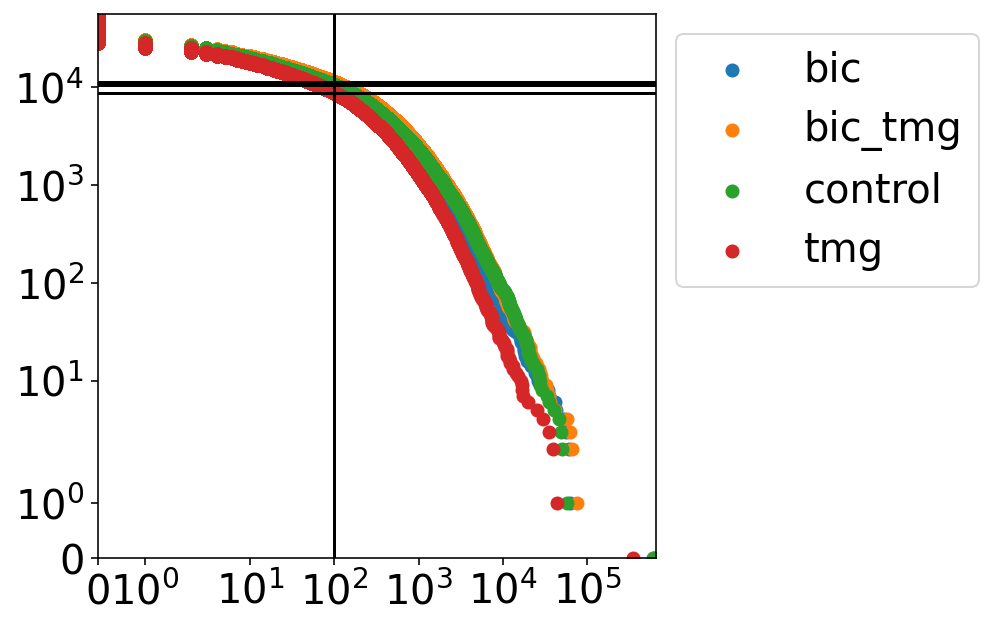

In [164]:
# gene cutoffs
fig, ax = plt.subplots(figsize=(5,5))
ng = []
co = []
for label, a in data.items():
    x = np.sort(nd(a.X.sum(0)))[::-1]
    y = np.arange(x.shape[0])

    # if you return the entropy, you can pass it here as a color
    ax.scatter(x,y, label=label)

    cutoff = 100
    top_g = 1000
    ngenes = np.where(x>cutoff)[0][-1]
    ng_cutoff = x[:top_g][-1]
    co.append(ng_cutoff)
    ng.append(ngenes)
    ax.axvline(x=cutoff, color='k')
    ax.axhline(y=ngenes, color='k')

ax.set(**{
    "yscale" : "symlog",
    "xscale": "symlog",
    "xlim": 0,
    "ylim": 0

})
ax.legend(bbox_to_anchor=(1,1), loc="upper left")
fig.show()

In [165]:
# actually do the cutoff on genes and log1p that dude
for idx, ((l, i), c) in enumerate(zip(data.items(), co)):
    data[l] = i[:,i.X.sum(0) > c].copy()
    data[l].layers["raw"] = data[l].X.copy()
    data[l].X = data[l].layers["log1p"].copy()

In [166]:
# neighrborhood graph then clustering then tsne
for idx, (_, i) in enumerate(data.items()):
    sc.pp.neighbors(i, use_rep="X")
    sc.tl.leiden(i)
    sc.tl.tsne(i, use_rep="X")

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,


In [167]:
for idx, (l, i) in enumerate(data.items()):
    print(i.obs.leiden.value_counts())

0     1777
1      729
2      522
3      505
4      433
5      341
6      179
7      160
8      129
9       79
10      77
11      60
12      23
Name: leiden, dtype: int64
0     627
1     564
2     405
3     321
4     261
5     232
6     208
7     180
8     139
9     135
10     67
11     23
Name: leiden, dtype: int64
0    267
2    243
1    243
3    242
4    210
5    164
6    139
7    127
8    125
9    109
Name: leiden, dtype: int64
0    173
1    169
2    144
3    131
4    115
5     80
6     73
7     67
8     37
9     30
Name: leiden, dtype: int64


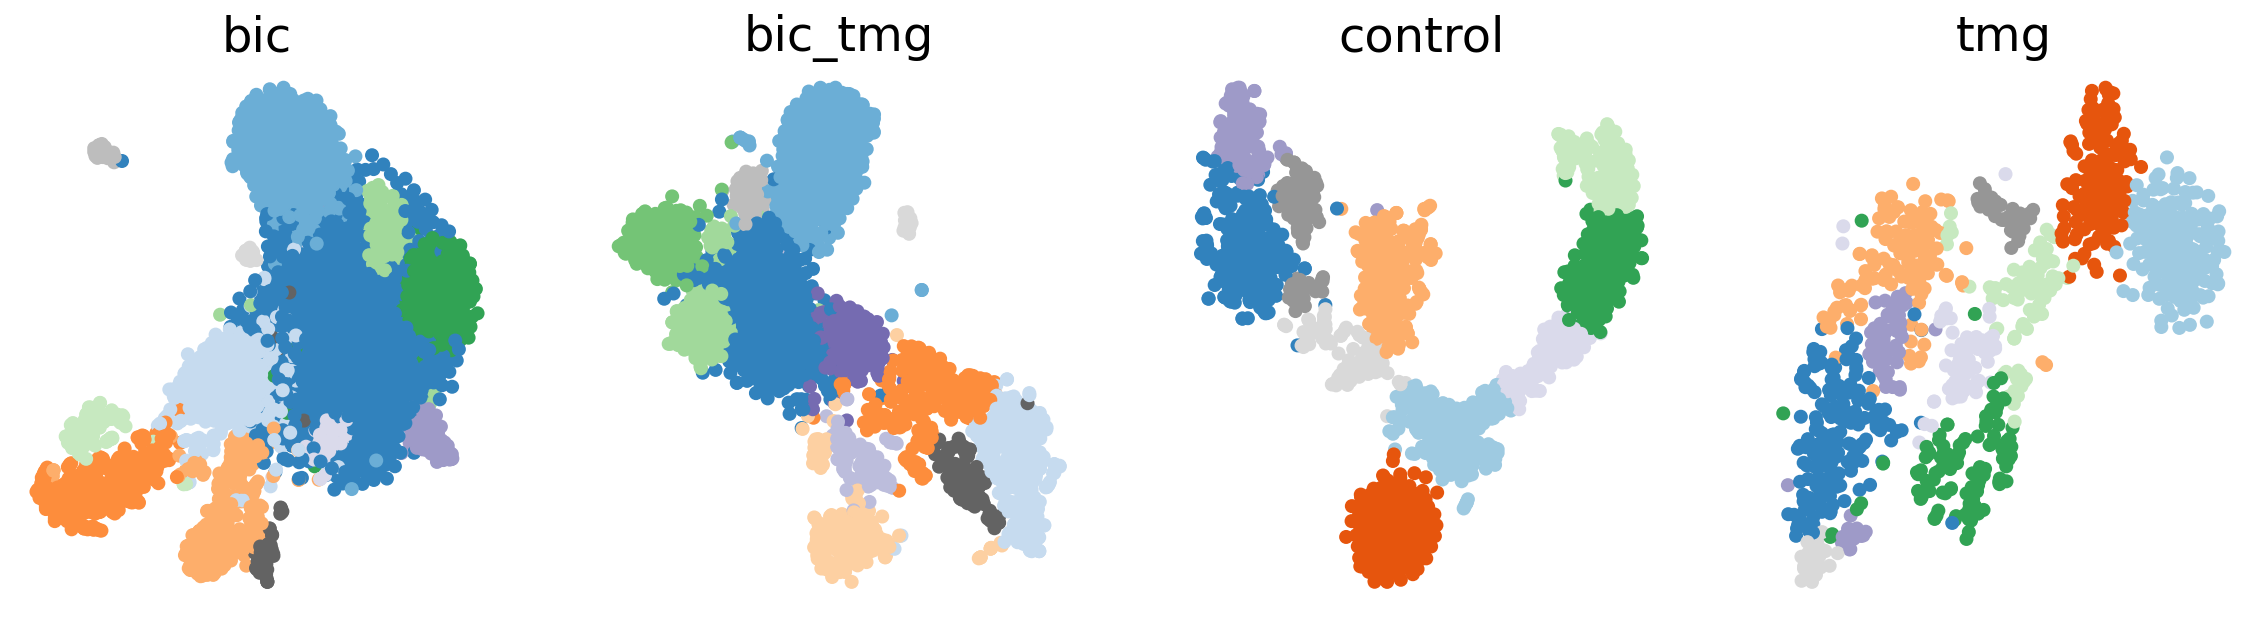

In [168]:
fig, axs = plt.subplots(figsize=(20, 5), ncols=len(data.keys()))

for idx, ((l, i), ax) in enumerate(zip(data.items(), axs)):
    x = i.obsm["X_tsne"][:,0]
    y = i.obsm["X_tsne"][:,1]
    c = i.obs.leiden.values.astype(int)
    ax.scatter(x,y, c=c, cmap="tab20c")
    ax.set(**{
        "title": l
    })

    ax.set_axis_off()
fig.show()

In [169]:
#@title dexpress

from scipy.stats import ks_2samp, ttest_ind
import numpy as np
import pandas as pd
import logging

logger = logging.getLogger()
logger.setLevel(logging.INFO)
logging.basicConfig(format='%(asctime)s - %(message)s', datefmt='%d-%b-%y %H:%M:%S')

import numpy as np
from statsmodels.stats.multitest import multipletests

def split_by_target(mat, targets, target, axis=0):
    """
    Split the rows of mat by the proper assignment
    
    mat = ndarray
    targets, length is equal to number of components (axis=0) or features (axis=1)
    target is a singular element from unique(assignments/features) 
    """
    if axis==0 and len(targets) != mat.shape[axis]: return -1
    if axis==1 and len(targets) != mat.shape[axis]: return -1
        
    mask = targets == target
    
    if axis==0:
        t_mat = mat[mask]  # target matrix
        c_mat = mat[~mask] # complement matrix
    elif axis==1:
        t_mat = mat[:, mask]  # target matrix
        c_mat = mat[:, ~mask] # complement matrix
    
    return (t_mat, c_mat)

def correct_pval(pval, nfeat, method):
    if method == 'bonferroni':
        pval_corr = np.minimum(pval*nfeat[:,None], 1.0)
    return pval_corr

def nd(arr):
    return np.asarray(arr).reshape(-1)
def correct_pvals(pvals):
    r = np.empty(np.shape(pvals))
    r[:] = np.nan
    for pidx, p in enumerate(pvals):
        mask = ~np.isnan(p)


    return r


def dexpress(mat, components, features, assignments, **kwargs):
    """
    mat: ndarray
    components: nparray
    features: nparray
    assignments: nparray, length is equal to length of components
    """
    nan_cutoff = kwargs.get("nan_cutoff", 0)
    
    unique = np.unique(assignments)
        
    ncomp = components.shape[0]
    nfeat = features.shape[0]
    nuniq = unique.shape[0]
    
    pval = np.empty((nuniq, nfeat)) # unique assignments by features 
    pval_corr = np.empty((nuniq, nfeat)) # unique assignments by features 
    stat = np.empty((nuniq, nfeat)) # unique assignments by features 
    es = np.empty((nuniq, nfeat)) # unique assignments by features 
    nfeatures = np.empty((nuniq))
    
    pval.fill(np.nan)
    pval_corr.fill(np.nan)
    stat.fill(np.nan)
    es.fill(np.nan)
    nfeatures.fill(np.nan)
    

    for tidx, t in enumerate(unique):
        logging.info("{} of {} assignments: {}".format(tidx+1, nuniq, t))
        t_mat, c_mat = split_by_target(mat, assignments, t, axis=0)
        
        pvalue = np.nan
        statistic = np.nan
        effect_size = np.nan

        # Keep only the genes for which it is in at least nan_cutoff*ncellsinclusters
        mask = np.asarray((t_mat>0).sum(axis=0) > nan_cutoff*t_mat.shape[0]).reshape(-1)

        t_mat = t_mat[:, mask]
        c_mat = c_mat[:, mask]
        # added

        # added
        if mask.sum()>0:
            test = ttest_ind(t_mat, c_mat, nan_policy="propagate", equal_var=False)
            pvalue = test.pvalue
            statistic = test.statistic
            effect_size = nd(t_mat.mean(axis=0)) - nd(c_mat.mean(axis=0))
            nfeatures[tidx] = mask.sum()
                
        pval[tidx,:][mask] = pvalue
        stat[tidx,:][mask] = statistic
        es[tidx,:][mask] = effect_size
    return (pval, stat, es, nfeatures)

def make_table(assignments, features, p_raw, p_corr, es):
    unique = np.unique(assignments)
    markers = pd.DataFrame(index=unique, columns=["gene", "p_raw", "p_corr", "es"])

    for uidx, u in enumerate(unique):
        markers.loc[u]["gene"] = features
        markers.loc[u]["p_raw"] = p_raw[uidx]
        markers.loc[u]["p_corr"] = p_corr[uidx]
        markers.loc[u]["es"] = es[uidx]

    markers = markers.apply(pd.Series.explode).reset_index()
    markers = markers[markers.notnull()["p_raw"]]
    markers = markers.rename(columns={"index": "group_id"})
    return markers

In [170]:
%%time
dfs = {}
for idx, (label, i) in enumerate(data.items()):
    mat           = i.X.toarray() # this is log1p
    components    = i.obs.index.values
    features      = i.var.gene.values
    assignments   = i.obs.leiden.values


    unique = np.unique(assignments)
    nan_cutoff = 0.9 # of elements in cluster
    corr_method = "bonferroni"


    p_raw, stat, es, nfeat = dexpress(mat, components, features, assignments, nan_cutoff=nan_cutoff)
    p_raw = p_raw/2
    p_corr = correct_pval(p_raw, nfeat, corr_method)

    s = stat

    df = make_table(assignments, features, p_raw, p_corr, es)

    # convert the 0 pvalues to the smallest possible float
    df["p_corr"][df.eval("p_corr == 0").values] = sys.float_info.min
    df = df.query("es > 0").query("p_corr < 0.05")
    df["condition"] = label
    dfs[label] = df

27-Jan-22 09:55:02 - 1 of 13 assignments: 0
27-Jan-22 09:55:02 - 2 of 13 assignments: 1
27-Jan-22 09:55:02 - 3 of 13 assignments: 10
27-Jan-22 09:55:02 - 4 of 13 assignments: 11
27-Jan-22 09:55:02 - 5 of 13 assignments: 12
27-Jan-22 09:55:03 - 6 of 13 assignments: 2
27-Jan-22 09:55:03 - 7 of 13 assignments: 3
27-Jan-22 09:55:03 - 8 of 13 assignments: 4
27-Jan-22 09:55:03 - 9 of 13 assignments: 5
27-Jan-22 09:55:03 - 10 of 13 assignments: 6
27-Jan-22 09:55:03 - 11 of 13 assignments: 7
27-Jan-22 09:55:03 - 12 of 13 assignments: 8
27-Jan-22 09:55:03 - 13 of 13 assignments: 9
27-Jan-22 09:55:03 - 1 of 12 assignments: 0
27-Jan-22 09:55:03 - 2 of 12 assignments: 1
27-Jan-22 09:55:03 - 3 of 12 assignments: 10
27-Jan-22 09:55:03 - 4 of 12 assignments: 11
27-Jan-22 09:55:03 - 5 of 12 assignments: 2
27-Jan-22 09:55:03 - 6 of 12 assignments: 3
27-Jan-22 09:55:03 - 7 of 12 assignments: 4
27-Jan-22 09:55:03 - 8 of 12 assignments: 5
27-Jan-22 09:55:03 - 9 of 12 assignments: 6
27-Jan-22 09:55:03 - 10

CPU times: user 716 ms, sys: 42.1 ms, total: 758 ms
Wall time: 749 ms


In [171]:
markers = pd.concat([i[1] for i in dfs.items()])
markers["condition_group"] = markers["condition"] + "." + markers["group_id"]
table = markers.groupby("condition_group")["gene"].apply(list)

In [172]:
table

condition_group
bic.1                                      [Slc1a2, Cst3, Apoe]
bic.10        [Itm2c, Atp1b1, Atp2b1, Ank3, Syt1, Atxn7l3b, ...
bic.11                                 [Hba-a1, Hba-a2, Hbb-bs]
bic.12                                          [Atp1a2, Ptgds]
bic.2         [Atp1b1, Syt1, Calm1, Rtn1, Calm2, Atp6v0c, Rn...
bic.3         [Ap1s3, Itm2c, Ptma, R3hdm1, Nucks1, Gm37357, ...
bic.4         [Atp1b1, Syt1, Atxn7l3b, Psap, Thra, Eif1, Paf...
bic.5                                                     [Bsg]
bic.6                                                    [Cst3]
bic.7         [Ap1s3, Itm2c, Ptma, Nucks1, Gm37357, Kifap3, ...
bic.8                  [Rack1, Rps3a3, Gm4821, Gm10036, Eef1a1]
bic.9                                            [Meg3, Snhg11]
bic_tmg.1                     [Atp1a2, Clu, Slc1a2, Cst3, Apoe]
bic_tmg.10                 [Qk, Ptprz1, Ptn, Apoe, Ncan, Cspg5]
bic_tmg.11               [Hba-a1, Hba-a2, Ftl1, Hbb-bt, Hbb-bs]
bic_tmg.2     [Epha4, Hn